# Interactive clustering
Make sure to fill in the day and chip name in the next box.

In [1]:
day = '20211229' # EXAMPLE: 'day0'
chip_name = '20211229_ab1_cpp1'#EXAMPLE: 'day0_ab1_cpp24'

In [2]:
import yaml
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

import sys
sys.path.insert(1, '../../')
# kchip imports
import kchip_py3.io as kchip_io
import kchip_py3.analyze as kchip_analyze

# Read in config file 
config_file = '../../configs/'+day+'/'+chip_name+'_config.yml'
with open(config_file, 'r') as ymlfile:
    config = yaml.load(ymlfile)

In [3]:
data_prefix = '../../data/interim/'+day+'/'+chip_name+'_' 
droplets = pd.read_csv(data_prefix+'droplets_d.csv',index_col=0)
# Troubleshooting the barcode pandas dataframe index
barcodes = pd.read_excel(config['barcodes']['path'],sheet_name='Barcodes',index_col=0)
labels = pd.read_excel(config['barcodes']['path'],sheet_name='Labels',index_col=0)

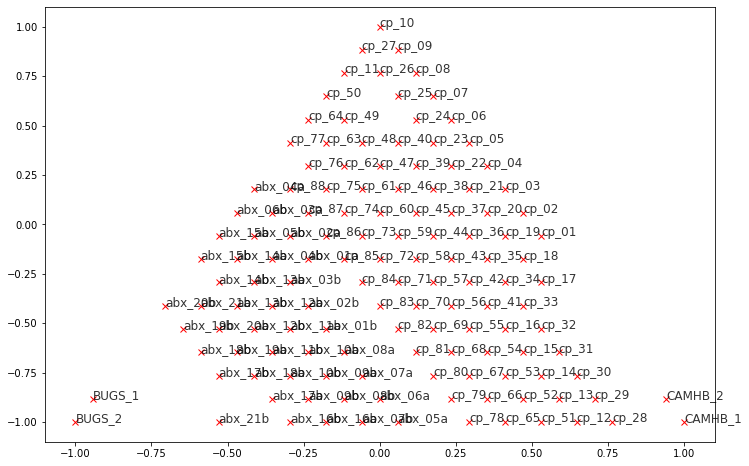

In [4]:
kchip_analyze.cluster_ref(config)
plt.gcf().set_size_inches(12,8)
figure_prefix = '../../figures/'+day+'/'+chip_name+'_'
plt.savefig(figure_prefix+'cluster_reference.png',dpi=300)

Total droplets identified:  225770
(116, 2)
Total clusters you should have: 134


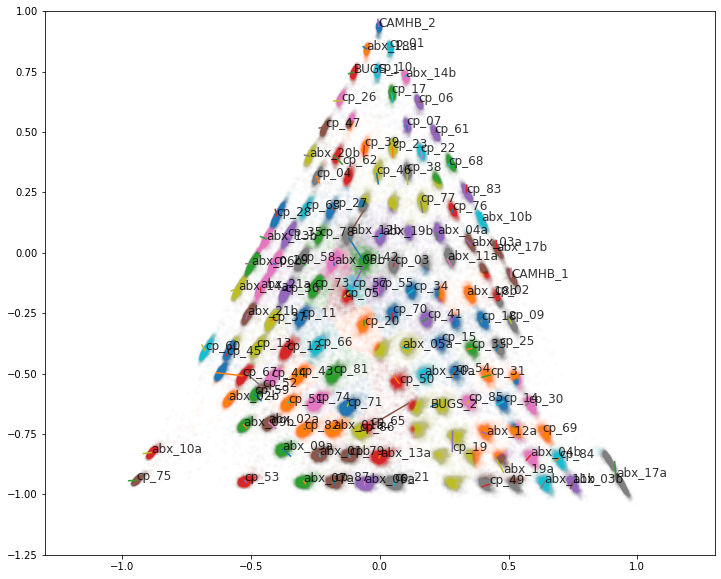

In [5]:
# ASSIGNS LABELS TO CLUSTERS
# Key error will likely appear
# This is because more clusters were found than labels provided
# Fix by increasing the number of min sample from the config file
# OR by using Interactive clustering code

config['barcodes']['cluster']['eps'] = 0.02 
config['barcodes']['cluster']['min_samples'] = 5

fig, ax = plt.subplots()
# Cluster droplets and map apriori labels to clusters
droplets, centroids, on_plane = kchip_analyze.identify_clusters(config,droplets,show=1,ax=ax)
droplets, centroids = kchip_analyze.map_labels_to_clusters(config, droplets, show=1,ax=ax)
# droplets.to_csv('droplets_clustered_scaled.csv')

print ('Total droplets identified: ', droplets.shape[0])
print(centroids.shape)
x = labels.fillna('_').values.reshape(labels.size,1)
all_labels = x[x != '_'].tolist()
print('Total clusters you should have:',len(all_labels))

plt.gca().set_xlim(-1.3,1.3)
plt.gca().set_ylim(-1.25, 1)
plt.gcf().set_size_inches(12,10)
# plt.savefig(newfolder+exp_date+'clusters_scaled_corr.png',bbox_inches='tight')

### Interactive clustering

In [7]:
# # Import the interactive tools
import kchip_py3.tools.interact as interact
import bqplot.pyplot as bqplt

# # Create InteractiveCluster object
centroids = droplets.groupby('Cluster')[['PlaneX','PlaneY']].median().values
rc = interact.InteractiveCluster(droplets[['PlaneX','PlaneY']].values[5000:10000,:],centroids)

# Show the plot
bqplt.show()

# Change the point opacities for better viewing, as desired
rc.sca_points.default_opacities = [.2]

### Identify missing clusters
If there are clusters missing from the plot above, identify the labels they would have using the reference chart and add those to the list below.

In [8]:
missing = [] # eg. ['cp_300', 'abx_52e', 'CAMHB_3']

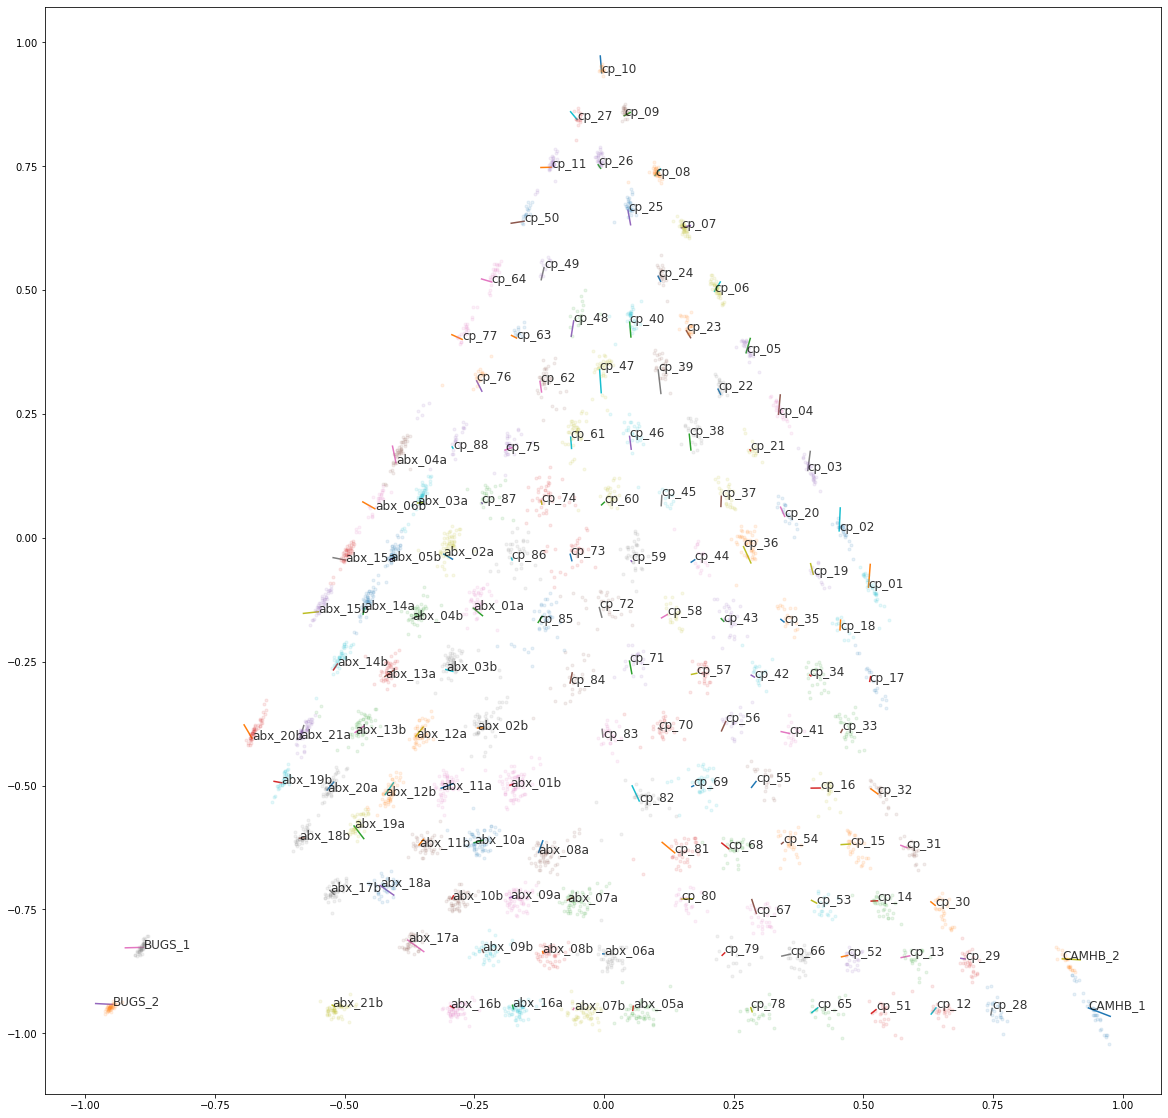

In [9]:
# Update the droplets dataframe with new cluster assignments
droplets['Cluster']=rc.cluster(droplets[['PlaneX','PlaneY']].values)

# Map labels to clusters
fig, ax = plt.subplots(figsize=(20,20))

# Use the updated cluster centroids from the interactive plot
droplets = kchip_analyze.map_labels_to_clusters(config,droplets,missing,show=1,ax=ax)[0]

# Replot the points to view the clusters

d = droplets.loc[:5e3] # only choose the first 5000 points so we don't overload matplotlib
for item in droplets['Cluster'].unique():
    xy = d.query('Cluster=='+str(item))[['PlaneX','PlaneY']].values
    ax.plot(xy[:,0],xy[:,1],'.',alpha=0.1)

# Save the triangle
plt.savefig(figure_prefix+'cluster_corrected_projected.png',bbox_inches='tight')
pd.DataFrame(missing,columns=['missing_clusters']).to_csv(data_prefix+'missing_clusters.csv')

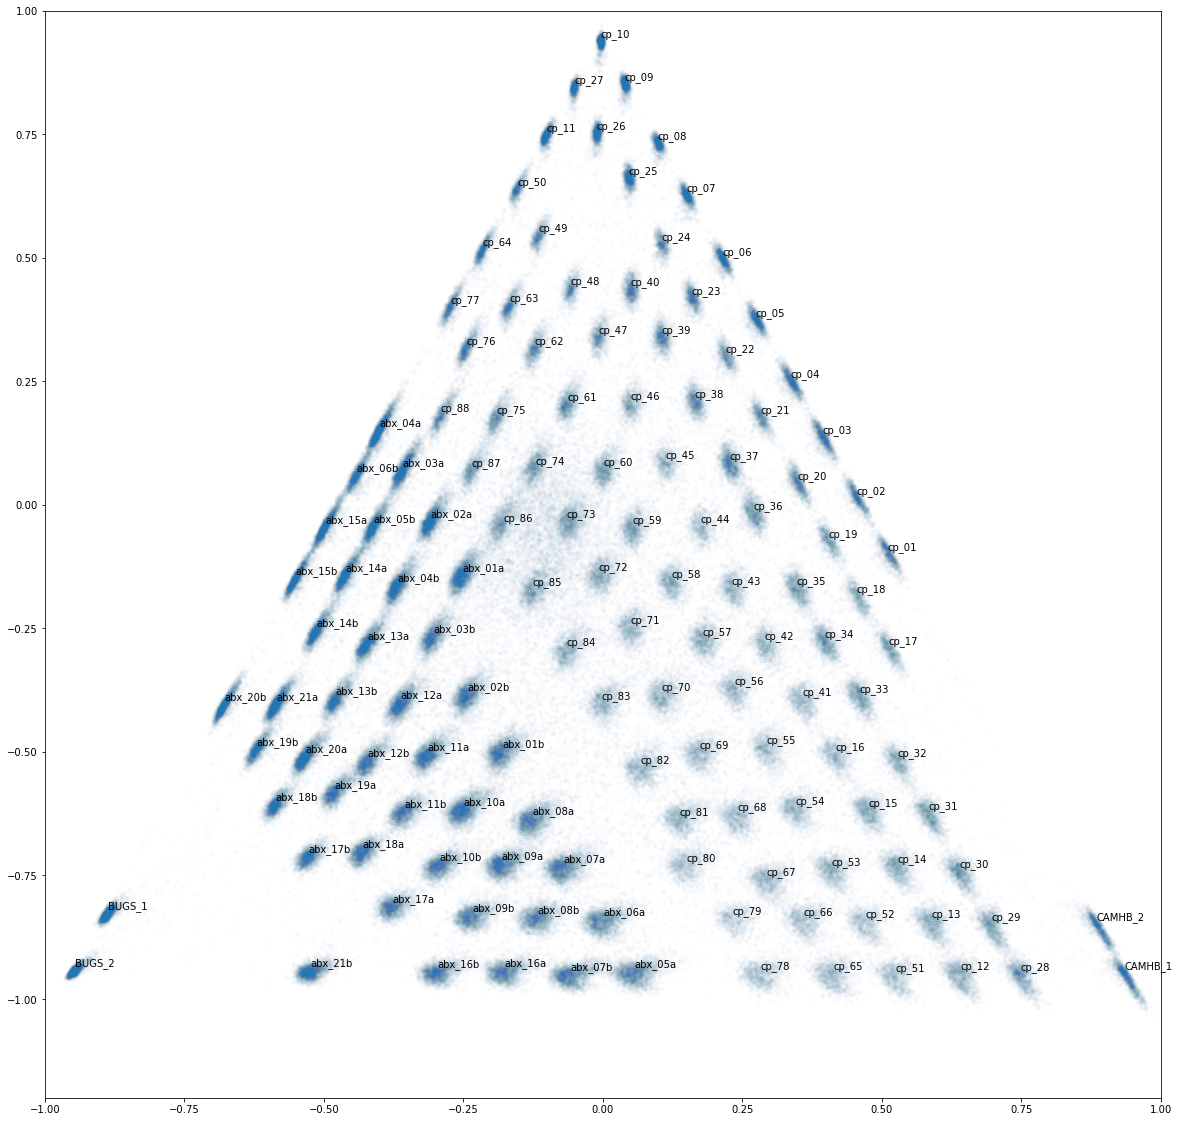

In [10]:
droplets['CentroidX'] = droplets.groupby('Label')['PlaneX'].transform('mean')
droplets['CentroidY'] = droplets.groupby('Label')['PlaneY'].transform('mean')
droplets['distance'] = np.sqrt((droplets.PlaneX-droplets.CentroidX)**2+\
                              (droplets.PlaneY-droplets.CentroidY)**2)
fig, ax = plt.subplots(figsize=(20,20))
plt.xlim([-1,1])
plt.ylim([-1.2,1])
ax.plot(droplets.PlaneX,droplets.PlaneY,'.',alpha=0.01)
d = droplets.groupby('Label').median()[['PlaneX','PlaneY']]
for label in d.index.values:
    ax.text(d.loc[label,'PlaneX'],d.loc[label,'PlaneY']+0.01,label)
plt.savefig(figure_prefix+'cluster_corrected.png',dpi=300)

In [11]:
droplets.to_csv(data_prefix+'clustered.csv')

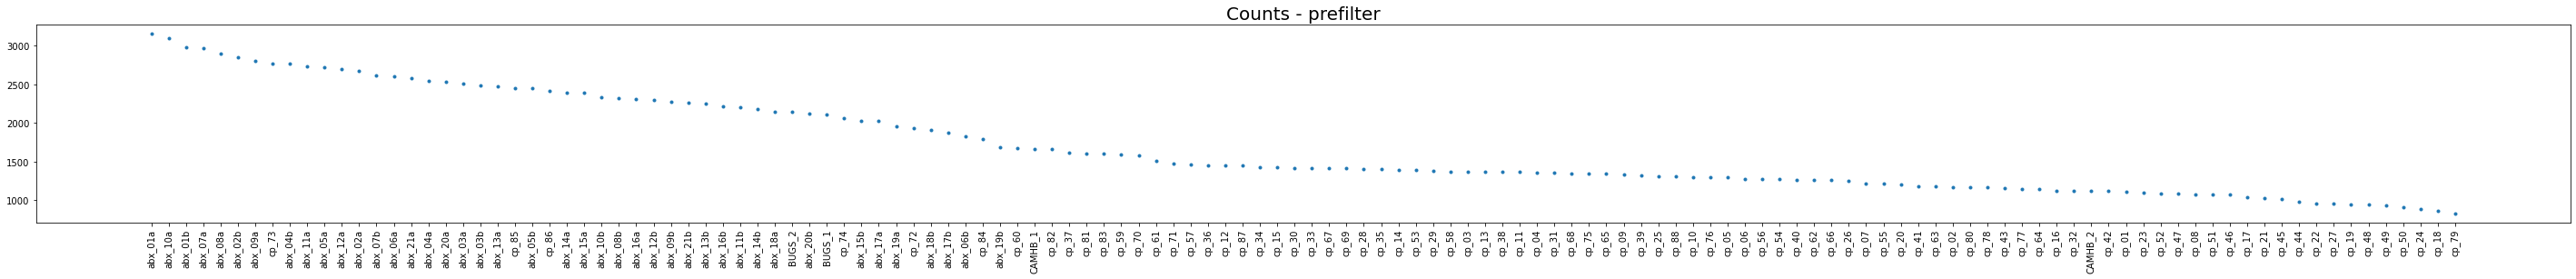

In [12]:
fig, axes = plt.subplots(1,1,figsize=(50,4))
plt.plot(droplets.Label.value_counts(),'.')
axes.set_xticks(range(len(droplets.Label.unique())))
axes.set_xticklabels(droplets.Label.value_counts().index,size=10,rotation=90)
axes.set_title('Counts - prefilter',size=20)
plt.savefig(figure_prefix+'cluster_count.png',dpi=300,bbox_inches='tight')